In [373]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Optional: also set width to avoid line wrapping
pd.set_option('display.width', None)

# Optional: disable column width truncation
pd.set_option('display.max_colwidth', None)

In [ ]:
all_players = nfl.import_players()
all_qbs = all_players[all_players['position'] == 'QB']
all_qbs.reset_index(inplace=True, drop='index')
all_qbs_id = list(all_qbs.gsis_id)

[1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

In [440]:
weekly_data = nfl.import_weekly_data(years=[i for i in range(1999,2024)])
weekly_data['completion_pct'] = weekly_data.completions / weekly_data.attempts
weekly_relevant = weekly_data[weekly_data['player_id'].isin(all_qbs_id)][['player_id', 'passing_tds', 'interceptions', 
                                                                          'sacks', 'sack_fumbles', 'rushing_tds', 
                                                                          'rushing_fumbles', 'completion_pct', 'passing_air_yards', 'attempts',
                                                                          'passing_yards', 'passing_epa', 'rushing_epa']]
weekly_relevant = weekly_relevant.groupby(['player_id', 'season']).agg({
    'passing_tds' : 'sum', 
    'interceptions' : 'sum',
    'sacks' : 'sum',
    'sack_fumbles' : 'sum',
    'rushing_tds' : 'sum',
    'rushing_fumbles' : 'sum', 
    'completion_pct' : 'mean',
    'passing_air_yards' : 'sum',
    'attempts' : 'sum',
    'player_id' : 'count',
    'passing_yards' : 'sum',
    'passing_epa' : 'sum',
    'rushing_epa' : 'sum'})
weekly_relevant = weekly_relevant.rename(columns={'player_id' : 'games_played'})
weekly_relevant = weekly_relevant[weekly_relevant['attempts'] > 100]


Downcasting floats.


KeyError: 'season'

In [439]:
stats2024 = nfl.import_pbp_data(years=[i for i in range(1999,2024)])
stats2024 = stats2024[(stats2024['qb_kneel'] == 0.0) & (stats2024['play_type'] != 'no_play')]
relevant = stats2024[['play_type', 'shotgun', 'qb_dropback', 'qb_scramble', 'air_yards', 'rushing_yards', 'id']]

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [ ]:
pass_stats = relevant[relevant['play_type'] == 'pass'].groupby(['id', 'season']).agg({'shotgun' : sum, 'qb_dropback' : sum})
pass_stats['shotgun'] = pass_stats.shotgun / pass_stats.qb_dropback
pass_stats.columns = ['shotgun_rate', 'total_passes']
pass_stats

,shotgun_rate,total_passes
id,,
00-0019596,0.839372,828.0
00-0022824,0.000000,1.0
00-0023459,0.805217,575.0
00-0026143,0.894422,502.0
00-0026158,0.825871,201.0
...,...,...
00-0037834,0.807229,249.0
00-0038102,0.911271,417.0
00-0038108,0.826531,98.0


In [ ]:
run_stats = relevant[relevant['play_type'] == 'run'].groupby(['id', 'season']).agg({'qb_scramble' : ['sum', 'count'], 'rushing_yards' : 'sum'})
run_stats.columns = ['qb_scramble_sum', 'total_runs', 'rushing_yards']
run_stats['qb_scramble_rate'] = run_stats.qb_scramble_sum / run_stats.total_runs
run_stats = run_stats[['qb_scramble_rate', 'total_runs', 'rushing_yards']]
run_stats

,qb_scramble_rate,total_runs,rushing_yards
id,,,
00-0019596,0.333333,12,12.0
00-0023459,0.684211,19,110.0
00-0026143,0.476190,21,77.0
00-0026158,0.500000,2,7.0
00-0026300,0.000000,3,6.0
...,...,...,...
00-0038120,0.000000,80,463.0
00-0038122,0.733333,15,65.0
00-0038124,0.000000,7,80.0


In [419]:
total_data = weekly_relevant.join(pass_stats).join(run_stats)

total_data['sacks_per_dropback'] = total_data['sacks'] / total_data['total_passes']
total_data['sack_fumbles'] = total_data['sack_fumbles'] / total_data['total_passes']

total_data['interceptions_per_game'] = total_data['interceptions'] / total_data['games_played']
total_data['passing_tds_per_game'] = total_data['passing_tds'] / total_data['games_played']
total_data['passing_air_yards_per_attempt'] = total_data['passing_air_yards'] / total_data['attempts']
total_data['passing_yards_per_game'] = total_data['passing_yards'] / total_data['games_played']

total_data['rushing_tds_per_game'] = total_data['rushing_tds'] / total_data['games_played']
total_data['rushing_fumbles_per_game'] = total_data['rushing_fumbles'] / total_data['games_played']
total_data['rushing_yards_per_game'] = total_data['rushing_yards'] / total_data['games_played']
total_data['rushing_yards_per_attempt'] = total_data['rushing_yards'] / total_data['total_runs']

total_data['pass_pct'] = total_data.total_passes / (total_data.total_passes + total_data.total_runs)

total_data['runs_per_game'] = total_data['total_runs'] / total_data['games_played']
total_data['attempts_per_game'] = total_data['attempts'] / total_data['games_played']

total_data['td:int'] = total_data['passing_tds'] / total_data['interceptions']
total_data['air_yard:completion_pct'] = total_data['passing_air_yards_per_attempt'] / total_data['completion_pct']

total_data = total_data[['sacks_per_dropback', 'attempts_per_game', 'rushing_tds_per_game', 'passing_tds_per_game', 'interceptions', 
                         'shotgun_rate', 'passing_air_yards_per_attempt', 'completion_pct',
                         'rushing_fumbles_per_game', 'rushing_yards_per_game', 'rushing_yards_per_attempt', 'pass_pct',
                         'air_yard:completion_pct', 'td:int']]

In [420]:
qb_names = list(total_data.merge(all_qbs[['gsis_id', 'display_name']], left_index=True, right_on='gsis_id').display_name)

In [421]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [422]:
scaler = StandardScaler()
X = scaler.fit_transform(total_data)
for P in range(1, 10):
    pca = PCA(n_components=P)
    pca.fit(X)
    print(pca.explained_variance_ratio_.sum())

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)


ValueError: Input X contains infinity or a value too large for dtype('float64').

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

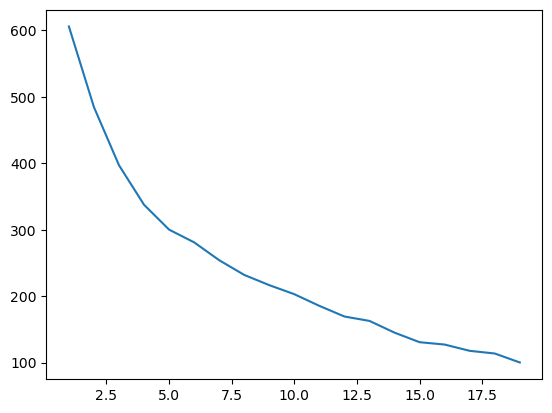

In [ ]:
import plotly.express as px
intertia = []
for K in range(1,20):
    kmeans = KMeans(n_clusters=K)
    intertia.append(kmeans.fit(X= X_pca).inertia_)

kmeans = KMeans(n_clusters=5)
groups = kmeans.fit_predict(X=X_pca)
    
plt.plot(range(1,20), intertia)
plt.show()
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:,1], color=groups, hover_name=qb_names)
fig.show()

In [424]:
tier_list = weekly_relevant.join(pass_stats).join(run_stats)
tier_list['tds_per_game'] = (tier_list['passing_tds'] + tier_list['rushing_tds']) / tier_list['games_played']
tier_list['yards_per_game'] = (tier_list['passing_yards'] + tier_list['rushing_yards'])/ tier_list['games_played']
tier_list['passing_yards_per_attempt'] = tier_list['passing_yards'] / tier_list['attempts']
tier_list['rushing_yards_per_run']  = tier_list['rushing_yards'] / tier_list['total_runs']
tier_list['turnovers_per_game'] = (tier_list['interceptions'] + tier_list['sack_fumbles'] + tier_list['rushing_fumbles']) / tier_list['games_played']
tier_list['td:turnover'] = tier_list['tds_per_game'] / tier_list['turnovers_per_game']
tier_list['passing_epa_per_game'] = tier_list['passing_epa'] / tier_list['games_played']
tier_list['rushing_epa_per_game'] = tier_list['rushing_epa'] / tier_list['games_played']


tier_list = tier_list[['tds_per_game', 'yards_per_game', 'passing_yards_per_attempt', 'rushing_yards_per_run', 
                       'turnovers_per_game', 'td:turnover', 'completion_pct', 'passing_epa_per_game', 'rushing_epa_per_game']]
tier_list.columns

Index(['tds_per_game', 'yards_per_game', 'passing_yards_per_attempt',
       'rushing_yards_per_run', 'turnovers_per_game', 'td:turnover',
       'completion_pct', 'passing_epa_per_game', 'rushing_epa_per_game'],
      dtype='object')

In [425]:
tiered_pca = PCA(n_components=1)
scaler = StandardScaler()
X = scaler.fit_transform(tier_list)
ranks = tiered_pca.fit_transform(X)
ranked_df = pd.DataFrame(data=[qb_names, ranks]).T.reset_index(drop='index').set_index(0)
ranked_df.columns = ['scores']
ranked_df['scores'] = ranked_df['scores'].apply(lambda x : x[0])


In [426]:
ranked_df.sort_values('scores')

,scores
0,
Patrick Mahomes,-4.895717
Jalen Hurts,-3.611117
Joe Burrow,-2.998781
Tua Tagovailoa,-2.918246
Josh Allen,-2.883634
Brock Purdy,-2.320694
Jimmy Garoppolo,-2.309113
Geno Smith,-1.998262
Dak Prescott,-1.925629
